In this series I will be modeling Singapore's HDB flats resale price. The first part is about building a model, following a standard ML problem process (EDA, Feature Engineering, Split train/test data, Fit model, Evaluation). The second part (coming soon™) will be about mlops. I will use `mlflow` to track and manage experiments & models.

Part 1 (This post)
- Train different models to predict resale price for Singapore's HDB

Part 2 (Coming soon™)
- Run & Log experiments and models using `mlflow`
- Save models to model registry
- Load and serve the best model

<details><summary>What are HDB flats?</summary>
    <ul>
    <li> HDB (Housing and Development Board) buildings are public housing blocks in Singapore. They were built and managed by the Housing and Development Board (HDB), a statutory board under the Ministry of National Development. 
    <li>
    HDB flats range from studio apartments to executive apartments, and are available for purchase or rent. Today 80% of Singapore's population live in HDB flats.
    </li>
    </li>
    <li>
    HDB flats are typically located in housing estates, which are self-contained communities with amenities such as schools, markets, and parks. The HDB also manages and maintains the estates, ensuring that they remain safe, clean and well-maintained.
    </li>
    </ul>

</details>

## 0. Import and read data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point
import folium

from math import radians, cos, sin, asin, sqrt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVR

In [2]:
df = pd.read_csv('./data/processed/intermediate-data.csv')
df['town'] = df['town'].replace({'KALLANG/WHAMPOA': 'KALLANG'})
df.shape

(133473, 18)

## 1. Exploratory Data Analysis

Preview dataset

In [3]:
df.head().T

,0,1,2,3,4
month,2017-01,2017-01,2017-01,2017-01,2017-01
town,ANG MO KIO,ANG MO KIO,ANG MO KIO,ANG MO KIO,ANG MO KIO
flat_type,2 ROOM,3 ROOM,3 ROOM,3 ROOM,3 ROOM
block,406,108,602,465,601
street_name_x,ANG MO KIO AVE 10,ANG MO KIO AVE 4,ANG MO KIO AVE 5,ANG MO KIO AVE 10,ANG MO KIO AVE 5
storey_range,10 TO 12,01 TO 03,01 TO 03,04 TO 06,01 TO 03
floor_area_sqm,44.0,67.0,67.0,68.0,67.0
flat_model,Improved,New Generation,New Generation,New Generation,New Generation
lease_commence_date,1979,1978,1980,1980,1980
remaining_lease,61 years 04 months,60 years 07 months,62 years 05 months,62 years 01 month,62 years 05 months


Checking for null/NaN data. In this case the percentage of rows having missing data are low, so it's safe to drop them

In [4]:
df.isnull().mean()

month                  0.000000
town                   0.000000
flat_type              0.000000
block                  0.000000
street_name_x          0.000000
storey_range           0.000000
floor_area_sqm         0.000000
flat_model             0.000000
lease_commence_date    0.000000
remaining_lease        0.000000
resale_price           0.000000
key                    0.000000
postal                 0.018513
latitude               0.018513
longitude              0.018513
street_name_y          0.018513
building               0.018513
address                0.018513
dtype: float64

In [5]:
df = df.drop(df[df['latitude'].isnull()].index)

Now let's look at the overall distribution of resale price, henceforth also refered to as the target variable.

The distribution is right-skewed with few but very high values. The median value (SGD 440k) is lower than average (SGD 470k)

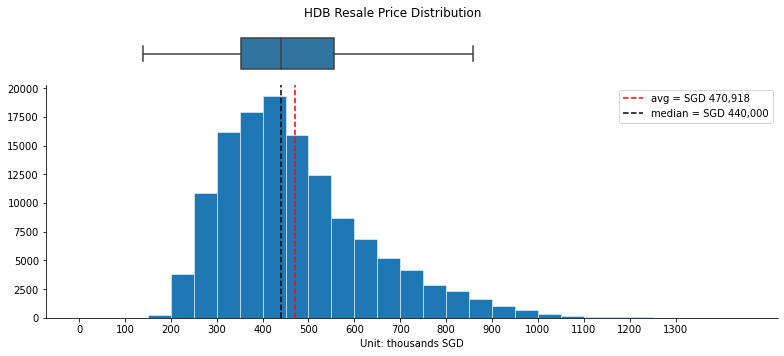

In [145]:
fig, axes = plt.subplots(2, 1, figsize=(11, 5), sharex=True, height_ratios=[1, 6])


df['resale_price'].hist(
    ec='white',
    linewidth=.5,
    bins=[_ * 50_000 for _ in range(30)],
    grid=False,
    ax=axes[1])

axes[1].axvline(df['resale_price'].mean(), ls='--', c='red', label=f"avg = SGD {df['resale_price'].mean():,.0f}")
axes[1].axvline(df['resale_price'].median(), ls='--', c='k', label=f"median = SGD {df['resale_price'].median():,.0f}")
axes[1].set_xticks([_ * 100_000 for _ in range(14)], labels=[_ * 100 for _ in range(14)])
axes[1].set_xlabel('Unit: thousands SGD')
axes[1].legend()
axes[0].axis('off')
sns.despine(ax=axes[1])

sns.boxplot(df['resale_price'], orient="h", showfliers=False, ax=axes[0])
sns.despine(ax=axes[0], left=True, bottom=True)
fig.suptitle('HDB Resale Price Distribution')
fig.tight_layout()

#### Numerical variables

Correlations between each numeric variables and the target value give us a good sense of how much predicting power they have.

Unsurprisingly, bigger and newer flats are positively correlated with resale price

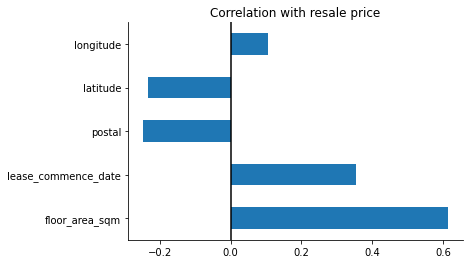

In [7]:
fig, ax = plt.subplots()
df.drop('resale_price', axis=1) \
    .corrwith(df['resale_price'], numeric_only=True) \
    .plot(kind='barh', ax=ax)
ax.axvline(x=0, c='k')
ax.set_title('Correlation with resale price')
sns.despine(ax=ax)

We can also study how much feature variables correlate with each other. If we solely care about having a good prediction, then it's ok to have correlated features! However, if we want to study the impact of each variable, it's helpful to remove redundant dimensions.

In the heatmap below, `latitude` and `postal` are highly correlated, we will drop at least 1 of them before fitting the models. However for now we will keep them to create a more useful feature.

<AxesSubplot: >

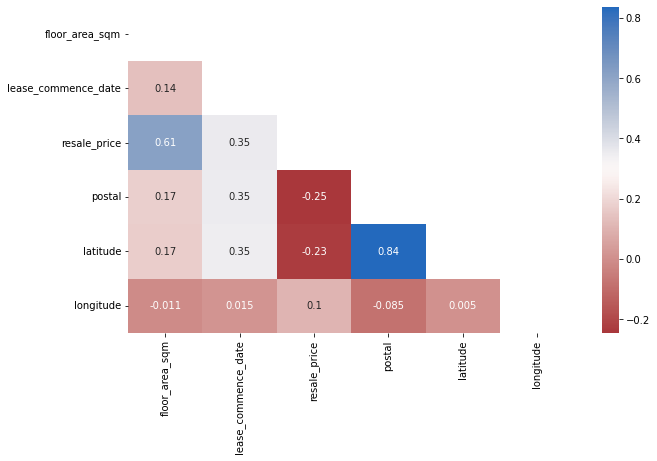

In [8]:
corr_matrix = df.corr(numeric_only=True).round(3)

# remove the top triangle of the matrix to simplify the heatmap
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    cmap=sns.color_palette("vlag_r", as_cmap=True),
    ax=ax)

#### Categorical variables

`block`, `building`, `address` contains too many categories. This might cause overfitting or computational issues then we will not be using those variables.

Perhaps the most useful feature we can use here is `flat_type`. The possible values are:
- 2 ROOM
- 3 ROOM
- 4 ROOM
- 5 ROOM
- Executive
- Multi-generationla

There are a few ways to deal with this data. For simplicity, I will convert them to number of rooms so we can have a nice numeric value.

In [9]:
df.select_dtypes('object').nunique()

month                68
town                 26
flat_type             6
block              2580
street_name_x       556
storey_range         17
flat_model           21
remaining_lease     653
key                 556
street_name_y       556
building            612
address            8896
dtype: int64

<AxesSubplot: xlabel='flat_type', ylabel='resale_price'>

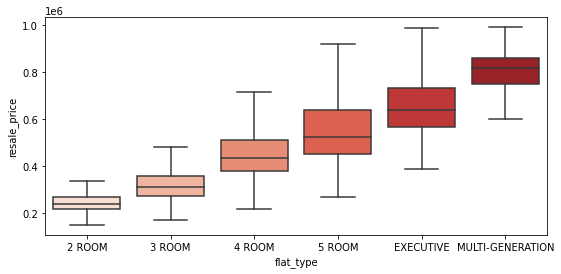

In [14]:
fig, ax = plt.subplots(figsize=(9, 4))

sns.boxplot(
    data=df,
    y='resale_price',
    x='flat_type',
    palette="Reds",
    showfliers=False,
    ax=ax)

## 2. Feature engineering

Intuitively, we know that location is one of the most important factor in determining house prices. We will need a way to add this information to our model. To visualize the impact of location, I've created a choropleth map.

It's visible from the map that the further towns have lower price range. 

In [49]:
sg_map = gpd.read_file('data/geojson/singapore_planning.geojson')
sg_map['PLN_AREA_N'] = sg_map['PLN_AREA_N'].replace({'OUTRAM': 'CENTRAL AREA', 'ROCHOR': 'CENTRAL AREA', 'DOWNTOWN CORE': 'CENTRAL AREA'})
sg_map = sg_map.dissolve('PLN_AREA_N')
sg_map.to_file('data/geojson/singapore_planning_clean.geojson', driver='GeoJSON')

mrt_map = gpd.read_file('data/geojson/singapore-mrt.min.geojson')
mrt_map = mrt_map.drop(['network', 'wikipedia_url', 'wikipedia_image_url', 'name_zh', 'name_hi'], axis=1, errors='ignore')
mrt_map = mrt_map[mrt_map['type']=='station']
mrt_map = mrt_map.reset_index(drop=True)

sg_map['agg.mean_4_ROOM'] = sg_map.index.map(df[df['flat_type']=='4 ROOM'].groupby('town')['resale_price'].mean().to_dict())
sg_map['agg.median_4_ROOM'] = sg_map.index.map(df[df['flat_type']=='4 ROOM'].groupby('town')['resale_price'].median().to_dict())
sg_map['agg.count_4_ROOM'] = sg_map.index.map(df[df['flat_type']=='4 ROOM']['town'].value_counts().to_dict())
sg_map['PLAN_AREA_N'] = sg_map.index

CITY_CENTER = (1.2801990449115896, 103.85175675603243)


town_map = folium.Map(location=[1.35, 103.8], zoom_start=11, tiles='CartoDB positron')

folium.Choropleth(
    geo_data=sg_map,
    name="4 ROOM",
    data=sg_map,
    columns=['PLAN_AREA_N', 'agg.mean_4_ROOM'],
    key_on="feature.properties.PLAN_AREA_N",
    fill_color="RdYlGn_r",
    nan_fill_color="None",
    fill_opacity=0.75,
    bins=[_ * 50_000 for _ in range(6, 17)],
    line_opacity=.1,
    legend_name="Average HDB resale value (SGD)",
    highlight=True,
).add_to(town_map)

style_function = lambda x: {
    'fillColor': '#ffffff',
    'color':'#000000', 
    'fillOpacity': 0.1, 
    'weight': 0.1}

highlight_function = lambda x: {
    'fillColor': '#000000', 
    'color':'#000000', 
    'fillOpacity': 0.50, 
    'weight': 0.1}
    
town_info_tooltips = folium.features.GeoJson(
    data=sg_map.round(),
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['PLAN_AREA_N', 'agg.mean_4_ROOM', 'agg.median_4_ROOM', 'agg.count_4_ROOM'],  # use fields from the json file
        aliases=['Town:', 'Mean (SGD):', 'Median (SGD): ', 'Number of HDBs:'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 5px;") 
    )
)

town_map.add_child(town_info_tooltips)
town_map.keep_in_front(town_info_tooltips)


folium.LayerControl().add_to(town_map)
# town_map.save("assets/town_map.html")
town_map

To determine how central a location it, I will calculate the straight line distance to a center point. For Singapore, I've selected the point having coordinate value `CITY_CENTER = (1.28019, 103.85175)`. This point was picked by eyeballing on google map.

In [63]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    
    # constant used to convert to km
    r = 6371
    
    return c * r



df['distance_from_center'] = df.apply(
    lambda x: haversine(
        x['longitude'],
        x['latitude'],
        CITY_CENTER[1],
        CITY_CENTER[0]), axis=1)

### Distance to the nearest MRT station

Other than distance to city center, close priximity to amenities and public transportations could also make the flats more attractive and hence having higher price. I will now calculate distance from the nearest MRT station to each of the HDB block.

To make calculations faster, I've (1) estimated the nearest location using Pythagorean theorem, and then (2) use the haversine formula above to determine actual distance in kilometers. This will save some calculation time.

In [ ]:
# hdb_ll -> np.ndarray

# latitude is the x-axis
# longitude is the y-axis
hdb_ll = df[['longitude', 'latitude']].values

# find nearst mrt
x_delta = (mrt_map.geometry.x.values.reshape(-1, 1) - hdb_ll[:, 0])
y_delta = (mrt_map.geometry.y.values.reshape(-1, 1) - hdb_ll[:, 1])
delta = ((x_delta ** 2) + (y_delta)**2) ** .5

df['nearest_mrt_id'] = delta.argmin(axis=0)
df['nearest_mrt_location'] = df['nearest_mrt_id'].map(pd.Series(mrt_map.geometry.values, index=mrt_map.index).to_dict())
df['nearest_mrt_longitude'] = df['nearest_mrt_location'].apply(lambda val: val.x)
df['nearest_mrt_latitude'] = df['nearest_mrt_location'].apply(lambda val: val.y)

df['distance_to_mrt'] = df.apply(lambda x:
    haversine(
        x['longitude'],
        x['latitude'],
        x['nearest_mrt_longitude'],
        x['nearest_mrt_latitude']),
        axis=1)

df = df.drop(['nearest_mrt_longitude', 'nearest_mrt_latitude', 'nearest_mrt_id'], axis=1, errors='ignore')

### Other features

Here's the remaining features to process:
* Convert remaining lease duration from year-month format to months
* Create a new feature called number of bedrooms from flat type (explained above)
* Averaged storey number since the original dataset list a range instead of exact floor number
* Drop values for rare types
* Drop highly correlated features
* Use boxlots to determine appropriate feature range. Optionally drop outliers.

In [ ]:
# convert `remaining_lease_months` from years months to months
df['remaining_lease'].str.contains('year').value_counts()
df['remaining_lease_months'] = df['remaining_lease'].str[:2].astype(int) * 12 + df['remaining_lease'].str[-9:-7].astype(int)


# convert flat type to number of rooms
# https://www.hdb.gov.sg/residential/buying-a-flat/finding-a-flat/types-of-flats
df['num_bedrooms'] = df['flat_type'].map({
    '1 ROOM': 0.5,
    '2 ROOM': 1,
    '3 ROOM': 2,
    '4 ROOM': 3,
    '5 ROOM': 4,
    'EXECUTIVE': 5,
    'MULTI-GENERATION': 6,
})

df = df.drop(df[df['num_bedrooms'].isnull()].index)

# convert storey range to mean of range
df['storey_range_feature'] = (df['storey_range'].str[:2].astype(int) + df['storey_range'].str[-2:].astype(int)) / 2

# drop highly correlated features
df = df.drop(['lease_commence_date', 'postal'], axis=1, errors='ignore')


numerical_feature_cols = [
    'num_bedrooms',
    'floor_area_sqm',
    'storey_range_feature',
    'remaining_lease_months',
    'distance_to_mrt',
    'distance_from_center',
    'floor_area_sqm',
    ]

fig, axes = plt.subplots(1, len(numerical_feature_cols), figsize=(16, 6))

for idx, col_name in enumerate(numerical_feature_cols):
    ax = axes[idx]
    sns.boxplot(df[col_name], ax=ax)
    sns.despine(ax=ax)
    ax.set_title(col_name.replace('_', '\n'), loc='left')

fig.tight_layout()

In [ ]:
# remove outliers
df = df[df['floor_area_sqm'] <= df['floor_area_sqm'].quantile(.95)]
df = df.dropna()
df = df.reset_index(drop=True)

In [ ]:
# correlation between numeric variables and target
fig, ax = plt.subplots()
df.drop('resale_price', axis=1) \
    .corrwith(df['resale_price'], numeric_only=True) \
    .sort_values(ascending=True) \
    .plot(kind='barh', ax=ax)
ax.axvline(x=0, c='k')
ax.set_title('Correlation with resale price')
sns.despine(ax=ax)

In [ ]:
# save data
# df.to_csv('./data/final/cleaned-data.csv', index=False)

## 3. Split train-test data

In [ ]:
X = df[numerical_feature_cols]
y = df['resale_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

## 4. Fit models

#### 4.1 Linear Regresssion (baseline)

I will first fit a simple estimator, which will be used as baseline.

In [ ]:
model = LinearRegression()
print(f'fitting {model.__class__.__name__}')
model.fit(X_train, y_train)
preds = model.predict(X_test)
rmse = mean_squared_error(y_test, preds, squared=False)
print(f'{rmse=:,.0f}')

#### 4.2 Decision Trees, Random Forest, GradientBoosting, SVR

In [ ]:
model = RandomForestRegressor(max_depth=20, n_estimators=100)
print(f'fitting {model.__class__.__name__}')
model.fit(X_train, y_train)
preds = model.predict(X_test)
rmse = mean_squared_error(y_test, preds, squared=False)
print(f'{rmse=:,.0f}')

In [ ]:
model = GradientBoostingRegressor()
print(f'fitting {model.__class__.__name__}')
model.fit(X_train, y_train)
preds = model.predict(X_test)
rmse = mean_squared_error(y_test, preds, squared=False)
print(f'{rmse=:,.0f}')

In [ ]:
model = LinearSVR()
print(f'fitting {model.__class__.__name__}')
model.fit(X_train, y_train)
preds = model.predict(X_test)
rmse = mean_squared_error(y_test, preds, squared=False)
print(f'{rmse=:,.0f}')

Out of the few models above, RandomForests perform the best. With a RMSE of 33.4k. In real terms, for a property that cost on average close to 500k, being off by 33k is decent.

However, there are a lot more that we can do here:
    1. Selecting different models
    2. Changing hyperparameters


Without mlflow, we will have to manually keep track of model parameteres, data sources, metrics, etc (such as in a google sheet). This is prone to errors and hard to keep track.

In the next post I will use mlflow to manage experiments and models.

## 5. Summary (so far)

- I've built some simple models to predict HDB resale prices. In addition to the given features (eg. living area, town name, flat type), I've added 2 features to measure centrality and proximity to MRT stations.

- RandomForest performs the best. The number of relatively uncorrelated trees operating as a committee will outperform most single complex model. We can improve the prediction by adding more relevant features such as to good schools, shopping malls, other amenities, etc.

- Conceptually, there could be other ways to predict house price, such as using a Time Series model (such as ARIMA)

_That's the end of part 1. In the next post of this series I will write about mlflow_